In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm, preprocessing, pipeline
import sklearn.linear_model as LM
from sklearn.feature_selection import VarianceThreshold

import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import cv
from scipy.stats import pearsonr, spearmanr
import lightgbm as lgb
import pickle

In [2]:
# from magine.enrichment.enrichr import get_background_list
# 
# reactome_dict = get_background_list('Reactome_2016')
# with open('reactome_term_dicts.pickle', 'wb') as handle:
#     reactome_dict = pickle.dump(reactome_dict, handle)

In [3]:


with open('reactome_term_dicts.pickle', 'rb') as handle:
    reactome_dict = pickle.load(handle)

In [4]:
with open('reactome_term_dicts.pickle', 'rb') as handle:
    reactome_dict = pickle.load(handle)
reactome_df = pd.DataFrame.from_dict(reactome_dict)

In [5]:
with open('reactome_term_dicts.pickle', 'rb') as handle:
    reactome_dict = pickle.load(handle)
reactome_df = pd.DataFrame.from_dict(reactome_dict)
reactome_df.term = reactome_df.term.str.split(' r-hsa').str.get(0)
reactome_df.head()

,term,gene_list,n_genes
0,dna damage reversal homo sapiens,"[ALKBH2, ALKBH3, ASCC1, ASCC2, ASCC3, MGMT]",6
1,reversal of alkylation damage by dna dioxygena...,"[ALKBH2, ALKBH3, ASCC1, ASCC2, ASCC3]",5
2,sperm:oocyte membrane binding homo sapiens,"[CD9, IZUMO1, IZUMO2, IZUMO3, IZUMO4]",5
3,sperm motility and taxes homo sapiens,"[CATSPER1, CATSPER2, CATSPER3, CATSPER4, CATSP...",9
4,fertilization homo sapiens,"[ACR, ADAM2, ADAM20, ADAM21, ADAM30, B4GALT1, ...",26


In [6]:
reactome_df[reactome_df.term.str.contains('apop')]

,term,gene_list,n_genes
287,tp53 regulates transcription of several additi...,"[BCL2L14, BCL6, BIRC5, CHM, NDRG1, PERP, PPP1R...",14
290,bh3-only proteins associate with and inactivat...,"[BAD, BBC3, BCL2, BCL2L1, BCL2L11, BID, BMF, P...",8
291,intrinsic pathway for apoptosis homo sapiens,"[AKT1, AKT2, AKT3, APAF1, BAD, BAK1, BAX, BBC3...",42
421,apoptosis induced dna fragmentation homo sapiens,"[CASP3, DFFA, DFFB, H1F0, HIST1H1A, HIST1H1B, ...",13
807,apoptosis homo sapiens,"[ACIN1, ADD1, AKT1, AKT2, AKT3, APAF1, APC, AP...",163
844,regulation of apoptosis homo sapiens,"[ARHGAP10, PAK2, PSMA1, PSMA2, PSMA3, PSMA4, P...",50
985,caspase activation via extrinsic apoptotic sig...,"[APPL1, CASP3, CASP8, CASP9, CD14, CFLAR, DAPK...",27
995,tnfr1-induced proapoptotic signaling homo sapiens,"[CASP8, CYLD, FADD, OTUD7B, RIPK1, TNF, TNFAIP...",13
1295,smac-mediated apoptotic response homo sapiens,"[CASP3, CASP7, CASP9, DIABLO, XIAP]",5
1296,apoptotic factor-mediated response homo sapiens,"[APAF1, CASP3, CASP7, CASP9, CYCS, DIABLO, XIAP]",7


In [7]:
apop_genes = reactome_df.loc[reactome_df.term=='apoptosis homo sapiens']['gene_list'].values[0]

dna_genes = reactome_df.loc[reactome_df.term=='dna repair homo sapiens']['gene_list'].values[0]

braf_genes = reactome_df.loc[reactome_df.term=='raf activation homo sapiens']['gene_list'].values[0]

# Model development below
Code is scattered, but the goal is to build a run_model function that takes in data, data type, and drug and returns single table comparing all models. Then the goal will be to iterate through data type combos and drugs and come up with a complete analysis output.

In [8]:
from load_data import AMLData

Welcome, James Pino!




UPGRADE AVAILABLE

A more recent version of the Synapse Client (2.7.0) is available. Your version (2.6.0) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 2.7.0 release notes

https://python-docs.synapse.org/build/html/news.html



In [9]:
# point of access for all data
data = AMLData()

significant not in columns.
p_value not in columns.


In [10]:
with open('large_fanos.txt', 'r') as f:
    large_fanos_hgnc = f.read().splitlines()


In [71]:
def run_gbt(x_train, y_train, x_test, y_test, feature_names, binarize=False):
    
    param = dict(
        device_type='cpu',
        boosting_type='gbdt',
        num_threads=8,
        n_jobs=None,
        objective='regression',
        metric='rmse',
        lambda_l1=1000,
        lambda_l2=100,
        reg_alpha=None,
        reg_lambda=None,
        learning_rate=.1,
        tree_learner='serial',
        max_bin=128,
        num_leaves=5,
        max_depth=-1,

        feature_fraction=1,  # .8

        bagging_freq=1,
        bagging_fraction=.8,
        subsample=None,
        subsample_freq=None,

        min_child_weight=0.2,
        min_data_in_leaf=2,
        min_child_samples=None,
        min_gain_to_split=None,
        colsample_bytree=None,
        min_split_gain=None,
        n_estimators=10000,
        verbose=-1,
        deterministic=True,
        random_state=10,

    )
    model_name = 'gbt'
    
        
    train_data = lgb.Dataset(x_train, label=y_train, feature_name=feature_names)
    validation_data = lgb.Dataset(x_test, label=y_test, feature_name=feature_names)
    num_round = 10000
    bst = lgb.train(
        param, 
        train_data, 
        num_round, 
        valid_sets=validation_data,
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=0)]
    )
    table = bst.feature_importance()
    feats = pd.Series(table, index=feature_names)
    selected_feat = feats[feats > 0].index.values
    n_feats = len(selected_feat)
#     selected_feat = '|'.join(selected_feat)
    train_pred = bst.predict(x_train, num_iteration=bst.best_iteration)
    preds = bst.predict(x_test, num_iteration=bst.best_iteration)
    error, r2, pearson, spearman = score_all(y_test, preds)
    
    return {
        'test_prediction': preds,
        'train_prediction': train_pred,
        'mse': error,
        'r2' : r2,
        'spearman': spearman,
        'pearsonr': pearsonr(y_test, preds)[0],
        'model': model_name,
        'feature_names': selected_feat,
        'n_feats': n_feats
    }
def score_all(y_test, preds):
    error = np.sqrt(metrics.mean_squared_error(y_test, preds))
    r2 = metrics.r2_score(y_test, preds)
    pearson = pearsonr(y_test, preds)[0]
    spearman = spearmanr(y_test, preds)[0]
#     print(f"RMSE: {error:0.3f} | R^2 {r2:0.3f} | R {pearson:0.3f}")
    return error, r2, pearson, spearman

In [72]:

def run_model(data, d_sets, drug_name, gene_subset=None, remove_fanos=False):
    df_subset = data.get_trainable_data(d_sets, drug_name)
    cols = list(set(df_subset.columns.values))
    cols.remove(drug_name)
    if remove_fanos:
        gns = [i+'_rna' for i in large_fanos_hgnc]
        cols = list(set(cols).difference(set(gns)))
    if gene_subset is not None:
        gns = [i+'_rna' for i in gene_subset]
        gns+= [i+'_prot' for i in gene_subset]
        cols = list(set(cols).intersection(set(gns)))
    features = df_subset[cols].copy()
    target = df_subset[drug_name].values
    
    n_features_before = features.shape[1]
    n_features = features.shape[1]
    
    print(f"Using {n_features} out of {n_features_before}"
          f" ({n_features_before - n_features} removed)")
    
#     features = pd.DataFrame(features, columns=feature_names)
    feature_names = list(set(features.columns.values))

    x_train, x_test, y_train, y_test = train_test_split(
        features,
        target,
        test_size=0.2,
        shuffle=True,
        random_state=13,
    )
    
    gbt_results = run_gbt(x_train, y_train, x_test, y_test, feature_names)


    for i in [gbt_results]:
        sns.regplot(x=y_test, y=i['test_prediction'], label=i['model'])
        sns.regplot(x=y_train, y=i['train_prediction'], label=i['model'])

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()
    plt.suptitle(f"Drug: {drug_name}")
    results = pd.DataFrame([gbt_results])
    print(results[['model', 'mse', 'r2', 'pearsonr', 'n_feats']])
    return results
    

[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `n_estimators` in params. Will use it instead of argument




Using 6945 out of 6945 (0 removed)
  model        mse        r2  pearsonr  n_feats
0   gbt  58.044695  0.498699  0.765756      237


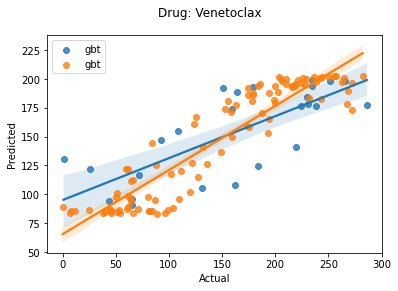

In [92]:
m1 = run_model(
    data,
    ['proteomics',],
    'Venetoclax',
    gene_subset=None
);

In [93]:
m1.head()

,test_prediction,train_prediction,mse,r2,spearman,pearsonr,model,feature_names,n_feats
0,"[124.80157860119506, 108.04023198015003, 178.4...","[182.17621539592372, 85.09182273460314, 88.924...",58.044695,0.498699,0.762735,0.765756,gbt,"[ATP1B3_prot, PKN1_prot, INPP4A_prot, HIP1R_pr...",237


In [84]:
all_set = set(sorted(m1.feature_names[0]))

[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `n_estimators` in params. Will use it instead of argument




Using 118 out of 118 (0 removed)
  model        mse        r2  pearsonr  n_feats
0   gbt  62.356746  0.421451  0.721562       36


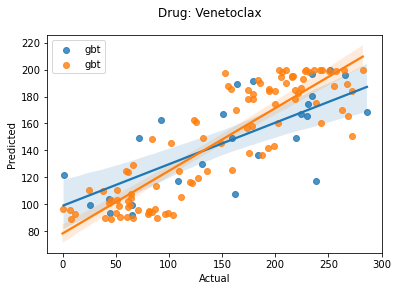

In [77]:
apop_m1 = run_model(
    data,
    ['proteomics'],
    'Venetoclax',
    gene_subset=apop_genes
);

In [ ]:
apop_set = set(sorted(apop_m1.feature_names[0]))

In [90]:
apop_set

{'ADD1_prot',
 'APAF1_prot',
 'BAD_prot',
 'BCL2_prot',
 'BID_prot',
 'CASP3_prot',
 'CASP6_prot',
 'CD14_prot',
 'DBNL_prot',
 'DFFB_prot',
 'GSN_prot',
 'MAGED1_prot',
 'NMT1_prot',
 'PAK2_prot',
 'PLEC_prot',
 'PPP3CC_prot',
 'PRKCD_prot',
 'PSMB10_prot',
 'PSMB4_prot',
 'PSMB9_prot',
 'PSMC1_prot',
 'PSMD11_prot',
 'PSMD13_prot',
 'PSMD1_prot',
 'PSMD3_prot',
 'PSMD6_prot',
 'PSMD7_prot',
 'PSMD9_prot',
 'RIPK1_prot',
 'ROCK1_prot',
 'STK24_prot',
 'TFDP1_prot',
 'TP53BP2_prot',
 'TRADD_prot',
 'YWHAH_prot',
 'YWHAQ_prot'}

In [89]:
all_set

{'AAMDC_prot',
 'ABCD1_prot',
 'ACSS1_prot',
 'ACTL6A_prot',
 'ADA2_prot',
 'AHDC1_prot',
 'ALKBH5_prot',
 'ANXA6_prot',
 'APOBR_prot',
 'ARAP1_prot',
 'ARCN1_prot',
 'ARF3_prot',
 'ARHGAP30_prot',
 'ARID3A_prot',
 'ATP11B_prot',
 'ATP1B3_prot',
 'BBX_prot',
 'BCL2_prot',
 'BCL7A_prot',
 'BLVRA_prot',
 'BPHL_prot',
 'C4BPA_prot',
 'C7orf50_prot',
 'CAMKK2_prot',
 'CARD16_prot',
 'CARD6_prot',
 'CBFA2T2_prot',
 'CCDC71_prot',
 'CD3EAP_prot',
 'CD93_prot',
 'CDC123_prot',
 'CEBPD_prot',
 'CERS6_prot',
 'CETN2_prot',
 'CHD3_prot',
 'CHMP4A_prot',
 'CLCC1_prot',
 'CMIP_prot',
 'COL4A3BP_prot',
 'COPA_prot',
 'COPG1_prot',
 'COPS6_prot',
 'COQ7_prot',
 'CORO2A_prot',
 'CORO7-PAM16_prot',
 'CRBN_prot',
 'CRCP_prot',
 'CRIPT_prot',
 'CTSF_prot',
 'DDB1_prot',
 'DHRS11_prot',
 'DKC1_prot',
 'DNAJC13_prot',
 'DNPH1_prot',
 'DOK2_prot',
 'DYNLT1_prot',
 'EDC4_prot',
 'EGLN1_prot',
 'EHBP1L1_prot',
 'EML4_prot',
 'EPDR1_prot',
 'FAM105A_prot',
 'FCGRT_prot',
 'FCHO1_prot',
 'FGD2_prot',
 'FLII_pr

In [87]:
len(apop_set.intersection(all_set))

2

[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `n_estimators` in params. Will use it instead of argument




Using 196 out of 196 (0 removed)
  model        mse        r2  pearsonr  n_feats
0   gbt  73.775956  0.190153  0.455148       40


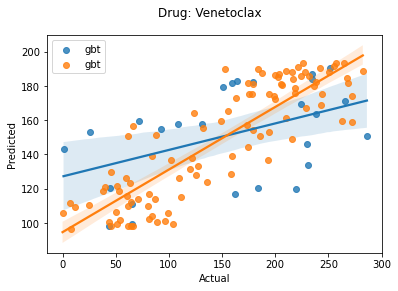

In [63]:
dna_m1 = run_model(
    data,
    ['proteomics'],
    'Venetoclax',
    gene_subset=dna_genes
);

[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `n_estimators` in params. Will use it instead of argument




Using 22843 out of 22843 (0 removed)
  model        mse        r2  pearsonr  n_feats
0   gbt  54.151178  0.450697  0.756602      139


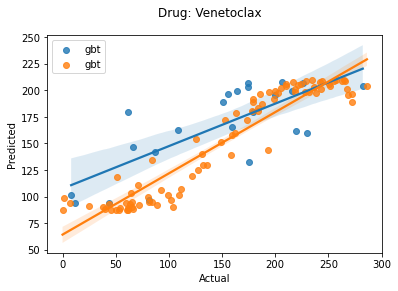

In [65]:
dna_m1 = run_model(
    data,
    ['rna_seq'],
    'Venetoclax',
    gene_subset=None
);

Using 25 out of 25 (0 removed)
        model        mse        r2  pearsonr       auc
0         gbt  42.049680  0.558631  0.748700       NaN
1  gbt_binary   0.436072  0.041283  0.516854  0.792424
2          EN  42.351747  0.552267  0.769889       NaN
3         SVM  45.448573  0.484395  0.706838       NaN
4         SVC   0.445086  0.001237  0.446290  0.584758
5       LASSO  44.262774  0.510949  0.733310       NaN


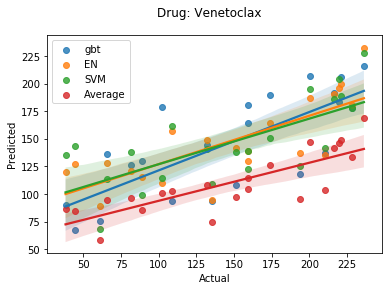

In [20]:

braf_m1 = run_model(
    data,
    ['rna_seq'],
    'Venetoclax',
    gene_subset=braf_genes
);

In [22]:
dna_m1['subset'] = 'DDR genes'
apop_m1['subset'] = 'Apoptosis genes'
m1['subset'] = 'All genes'
braf_m1['subset'] = 'BRAF genes'
combined = pd.concat([dna_m1, apop_m1, m1, braf_m1], ignore_index=True)
combined = combined.loc[combined.model=='gbt'].copy()
combined.sort_values('subset', inplace=True)
combined[['subset', 'pearsonr', 'r2', 'mse']]

[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `n_estimators` in params. Will use it instead of argument




Using 16190 out of 16190 (0 removed)
  model        mse       r2  pearsonr  n_feats
0   gbt  55.129009  0.43068    0.7364      306


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `n_estimators` in params. Will use it instead of argument




Using 22843 out of 22843 (0 removed)
  model        mse        r2  pearsonr  n_feats
0   gbt  54.900123  0.435398  0.746066      326


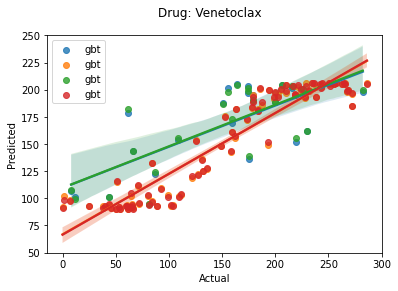

In [81]:
remove_le = run_model(
    data,
    ['rna_seq',],
    'Venetoclax',
    remove_fanos=True,
    gene_subset=None
);

with_le = run_model(
    data,
    ['rna_seq',],
    'Venetoclax',
    remove_fanos=False,
    gene_subset=None
);

In [83]:

remove_le['subset'] = 'Remove LE'
with_le['subset'] = 'All genes'

combined = pd.concat([remove_le, with_le], ignore_index=True)
combined = combined.loc[combined.model=='gbt'].copy()
combined.sort_values('subset', inplace=True)
combined[['subset', 'pearsonr', 'r2', 'mse']]

,subset,pearsonr,r2,mse
1,All genes,0.746066,0.435398,54.900123
0,Remove LE,0.736400,0.430680,55.129009


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `n_estimators` in params. Will use it instead of argument




Using 6945 out of 6945 (0 removed)
  model        mse        r2  pearsonr  n_feats
0   gbt  58.044695  0.498699  0.765756      237


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `n_estimators` in params. Will use it instead of argument




Using 118 out of 118 (0 removed)
  model        mse        r2  pearsonr  n_feats
0   gbt  62.356746  0.421451  0.721562       36


,test_prediction,train_prediction,mse,r2,spearman,pearsonr,model,feature_names,n_feats,subset
0,"[124.80157860119506, 108.04023198015003, 178.4...","[182.17621539592372, 85.09182273460314, 88.924...",58.044695,0.498699,0.762735,0.765756,gbt,"[ATP1B3_prot, PKN1_prot, INPP4A_prot, HIP1R_pr...",237,All genes
1,"[136.31604324716417, 107.22188099089873, 174.1...","[160.56075082066386, 92.76822789252981, 96.093...",62.356746,0.421451,0.747009,0.721562,gbt,"[CASP6_prot, PRKCD_prot, DBNL_prot, ADD1_prot,...",36,Apop genes


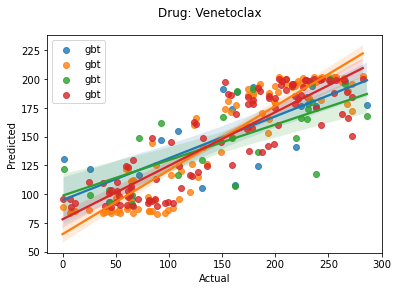

In [79]:
def compare_two_scenarios():
    control = run_model(
        data, 
        ['proteomics'],
        'Venetoclax',
        gene_subset=None
    );
    
    control['subset'] = 'All genes'
    
    variable = run_model(
        data, 
        ['proteomics'],
        'Venetoclax',
        gene_subset=apop_genes
    );
    
    variable['subset'] = 'Apop genes'
    

    df = pd.concat([control, variable], ignore_index=True)
    df = df.loc[df.model=='gbt'].copy()
    return df
compare_two_scenarios()